In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats
from scipy.stats import norm
print(scipy.__version__)


1.16.3


Todos
- normalize the graphs themselves
- ensure units are sensical
- clean everything up, make sure best representation possible

In [3]:
TIME_HORIZON = "1 year"

# Gaussian return model parameters
mu = 0.15       # mean yearly return of 12%
sigma = 0.20    # yearly volatility (20%)

# Confidence level for VaR (used later)
confidence_level = 0.95
alpha_tail = 1.0 - confidence_level  # left-tail probability

initial_investment = 1000000


Asset Return Distribution (Gaussian)
-----------------------------------
Time horizon           : 1 year
Distribution           : Normal (Gaussian)
Mean return (mu)       : 0.150000  (15.000%)
Volatility (sigma)     : 0.200000  (20.00%)
Variance               : 4.000000e-02
Confidence level (VaR) : 95.00%
Tail probability       : 5.00%
Z-score at 95.0% confidence: -1.6449
VaR (return) at 95.0% confidence: -0.1790 or -17.90%
VaR (dollars) at 95.0% confidence: $178,970.73


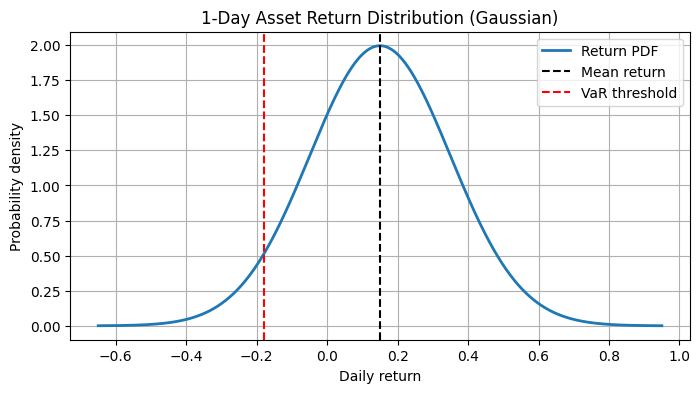

In [4]:
# ------------------------------------------------------------
# 2) Print all distribution parameters (explicit + report-ready)
# ------------------------------------------------------------
print("Asset Return Distribution (Gaussian)")
print("-----------------------------------")
print(f"Time horizon           : {TIME_HORIZON}")
print(f"Distribution           : Normal (Gaussian)")
print(f"Mean return (mu)       : {mu:.6f}  ({mu*100:.3f}%)")
print(f"Volatility (sigma)     : {sigma:.6f}  ({sigma*100:.2f}%)")
print(f"Variance               : {sigma**2:.6e}")
print(f"Confidence level (VaR) : {confidence_level:.2%}")
print(f"Tail probability       : {alpha_tail:.2%}")


# computing var analytically
z_score = norm.ppf(1 - confidence_level)
var_return = mu + z_score * sigma

# Example: If initial investment was $1,000,000
var_dollars = initial_investment * var_return

print(f"Z-score at {confidence_level*100}% confidence: {z_score:.4f}")
print(f"VaR (return) at {confidence_level*100}% confidence: {var_return:.4f} or {var_return:.2%}")
print(f"VaR (dollars) at {confidence_level*100}% confidence: ${-var_dollars:,.2f}")

# ------------------------------------------------------------
# 3) Visualize the return distribution
# ------------------------------------------------------------

# Plot range: ±4σ captures essentially all probability mass
x = np.linspace(mu - 4*sigma, mu + 4*sigma, 1000)
pdf = norm.pdf(x, loc=mu, scale=sigma)

plt.figure(figsize=(8, 4))
plt.plot(x, pdf, label="Return PDF", linewidth=2)

# Mark mean
plt.axvline(mu, color="black", linestyle="--", label="Mean return")

# Mark VaR threshold (left tail)
var_threshold = norm.ppf(alpha_tail, loc=mu, scale=sigma)
plt.axvline(var_threshold, color="red", linestyle="--", label="VaR threshold")

plt.xlabel("Daily return")
plt.ylabel("Probability density")
plt.title("1-Day Asset Return Distribution (Gaussian)")
plt.legend()
plt.grid(True)
plt.show()

<class 'numpy.ndarray'>
Monte Carlo VaR Estimation (Gaussian 1-day returns)
--------------------------------------------------
Time horizon           : 1 year
Distribution           : R ~ N(mu, sigma^2)
mu                     : 0.150000 (15.000%)
sigma                  : 0.200000 (20.00%)
Confidence level       : 95.00%
Tail probability       : 5.00%
MC samples (N)         : 200,000

VaR (MC estimate)      : 0.179134
VaR (analytic truth)   : 0.178971
Absolute error         : 0.000164
Relative error         : 0.0914%


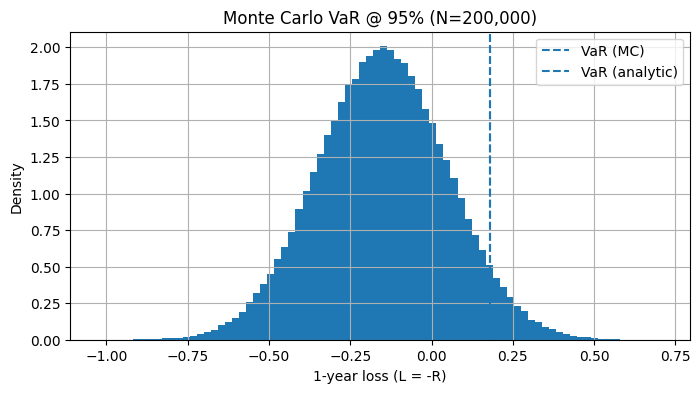

In [17]:
# ------------------------------------------------------------
# 2) Classical Monte Carlo VaR estimation (1-year Gaussian returns)
# ------------------------------------------------------------
# Assumption from previous bullet:
#   R ~ Normal(mu, sigma^2)  for 1-year return R
#
# VaR at confidence level c (e.g., 95%) is the loss threshold L* such that:
#   P(L <= L*) = c,  where L = -R
#
# Equivalently, VaR_c is the (1-c) left-tail quantile of returns, converted to a positive loss:
#   VaR_c = - Quantile_{(1-c)}(R)

# Monte Carlo settings
N = 200_000                # number of simulated days (samples)
SEED = 734324              # reproducibility for benchmarking
rng = np.random.default_rng(SEED)

# --- 1) Generate Monte Carlo samples of returns ---
returns = rng.normal(loc=mu, scale=sigma, size=N)
print(type(returns))

# --- 2) Convert returns to losses (positive numbers = losses) ---
losses = -returns

# --- 3) Monte Carlo VaR estimate: confidence-level quantile of losses ---
# VaR_95 is the 95th percentile of losses, i.e. only 5% of days are worse.
VaR_mc = float(np.quantile(losses, confidence_level, method="linear"))

# --- 4) Ground-truth (analytic) VaR for Gaussian (for benchmarking) ---
# VaR_true = -(mu + sigma * z_alpha_tail), where z_alpha_tail = Phi^{-1}(alpha_tail)
VaR_true = float(-(mu + sigma * norm.ppf(alpha_tail)))

# --- 5) Report results ---
abs_err = abs(VaR_mc - VaR_true)
rel_err = abs_err / abs(VaR_true) if VaR_true != 0 else np.nan

print("Monte Carlo VaR Estimation (Gaussian 1-day returns)")
print("--------------------------------------------------")
print(f"Time horizon           : {TIME_HORIZON}")
print(f"Distribution           : R ~ N(mu, sigma^2)")
print(f"mu                     : {mu:.6f} ({mu*100:.3f}%)")
print(f"sigma                  : {sigma:.6f} ({sigma*100:.2f}%)")
print(f"Confidence level       : {confidence_level:.2%}")
print(f"Tail probability       : {alpha_tail:.2%}")
print(f"MC samples (N)         : {N:,}")
print()
print(f"VaR (MC estimate)      : {VaR_mc:.6f}")
print(f"VaR (analytic truth)   : {VaR_true:.6f}")
print(f"Absolute error         : {abs_err:.6f}")
print(f"Relative error         : {rel_err:.4%}")

# --- 6) Minimal diagnostic plot: loss distribution + VaR markers ---
# This plot is helpful for presentations: shows the loss distribution and where VaR sits.
plt.figure(figsize=(8, 4))
plt.hist(losses, bins=80, density=True)
plt.axvline(VaR_mc, linestyle="--", label="VaR (MC)")
plt.axvline(VaR_true, linestyle="--", label="VaR (analytic)")
plt.xlabel("1-year loss (L = -R)")
plt.ylabel("Density")
plt.title(f"Monte Carlo VaR @ {confidence_level:.0%} (N={N:,})")
plt.legend()
plt.grid(True)
plt.show()

Running the error convergence analysis for MC

In [9]:
# -----------------------------
def mc_var_estimate(mu: float, sigma: float, confidence_level: float, n_samples: int, rng: np.random.Generator) -> float:
    """
    One MC estimate of VaR:
    - sample returns R
    - compute losses L = -R
    - return empirical confidence_level-quantile of losses
    """
    returns = rng.normal(loc=mu, scale=sigma, size=n_samples)
    losses = -returns
    return float(np.quantile(losses, confidence_level, method="linear"))


In [18]:
# Sample sizes to test (log-spaced is standard for convergence studies)
sample_sizes = [200, 500, 1_000, 2_000, 5_000, 10_000, 20_000, 50_000, 100_000]

# Repeat each N to estimate variability (important for tail quantiles)
n_trials = 200

results = []
for N in sample_sizes:
    estimates = np.empty(n_trials, dtype=float)

    for t in range(n_trials):
        estimates[t] = mc_var_estimate(mu, sigma, confidence_level, N, rng)

    err = estimates - VaR_true

    results.append({
        "N": int(N),
        "mean_est": float(np.mean(estimates)),
        "std_est": float(np.std(estimates, ddof=1)),
        "mae": float(np.mean(np.abs(err))),                     # mean absolute error
        "rmse": float(np.sqrt(np.mean(err**2))),                # root mean squared error
        "p50_abs_err": float(np.median(np.abs(err))),           # typical error
        "p90_abs_err": float(np.quantile(np.abs(err), 0.90)),   # tail of error distribution
    })

Basic prints for benchmarking analysis

In [19]:
print("Convergence summary (MC VaR vs theoretical)")
print("------------------------------------------")
print("   N      mean_est     std_est      MAE        RMSE      median|err|   p90|err|")
for r in results:
    print(
        f"{r['N']:>7}  {r['mean_est']:+.6f}  {r['std_est']:.6f}  "
        f"{r['mae']:.6f}  {r['rmse']:.6f}  {r['p50_abs_err']:.6f}   {r['p90_abs_err']:.6f}"
    )


Convergence summary (MC VaR vs theoretical)
------------------------------------------
   N      mean_est     std_est      MAE        RMSE      median|err|   p90|err|
    200  +0.171335  0.030395  0.024921  0.031265  0.020397   0.051643
    500  +0.175993  0.017905  0.014389  0.018107  0.012117   0.029484
   1000  +0.177965  0.014078  0.011218  0.014079  0.009096   0.023084
   2000  +0.179672  0.008636  0.007156  0.008643  0.006764   0.014080
   5000  +0.179047  0.006060  0.004662  0.006045  0.003960   0.010239
  10000  +0.179114  0.004552  0.003684  0.004543  0.003345   0.007240
  20000  +0.178886  0.003081  0.002438  0.003075  0.002029   0.004895
  50000  +0.179013  0.001908  0.001521  0.001904  0.001311   0.003031
 100000  +0.178941  0.001297  0.001015  0.001294  0.000861   0.002123


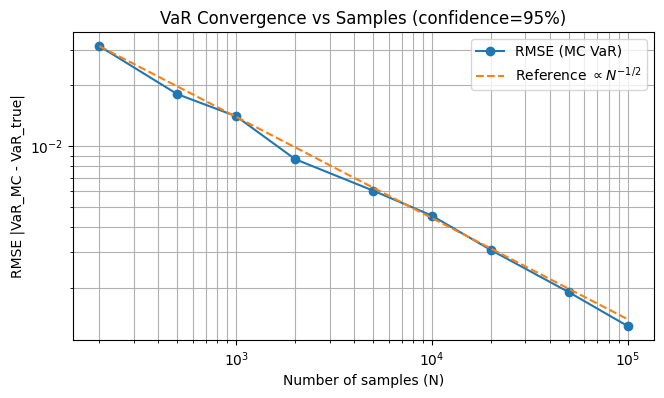

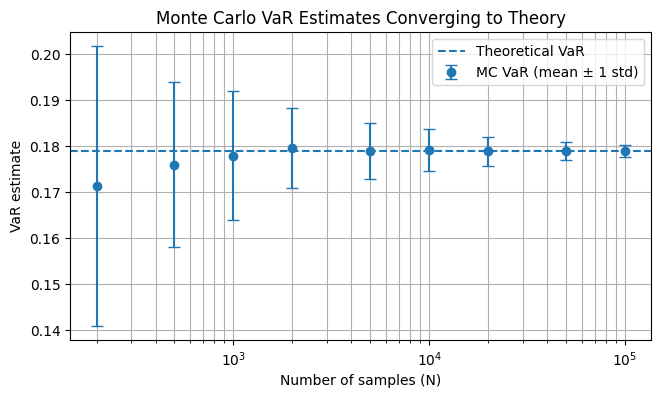

In [20]:
Ns = np.array([r["N"] for r in results], dtype=float)
rmse = np.array([r["rmse"] for r in results], dtype=float)

plt.figure(figsize=(7.5, 4))
plt.loglog(Ns, rmse, marker="o", label="RMSE (MC VaR)")

# Reference slope line ~ N^{-1/2} anchored at the first point (visual guide only)
ref = rmse[0] * (Ns / Ns[0]) ** (-0.5)
plt.loglog(Ns, ref, linestyle="--", label=r"Reference $\propto N^{-1/2}$")

plt.xlabel("Number of samples (N)")
plt.ylabel("RMSE |VaR_MC - VaR_true|")
plt.title(f"VaR Convergence vs Samples (confidence={confidence_level:.0%})")
plt.grid(True, which="both")
plt.legend()
plt.show()

# (B) Mean estimate with error bars (±1 std across trials) vs N
mean_est = np.array([r["mean_est"] for r in results], dtype=float)
std_est = np.array([r["std_est"] for r in results], dtype=float)

plt.figure(figsize=(7.5, 4))
plt.errorbar(Ns, mean_est, yerr=std_est, fmt="o", capsize=4, label="MC VaR (mean ± 1 std)")
plt.axhline(VaR_true, linestyle="--", label="Theoretical VaR")
plt.xscale("log")
plt.xlabel("Number of samples (N)")
plt.ylabel("VaR estimate")
plt.title("Monte Carlo VaR Estimates Converging to Theory")
plt.grid(True, which="both")
plt.legend()
plt.show()